In [62]:
from math import log, pow, exp, sqrt, fabs, e
from scipy.stats import norm
import pandas as pd
from datetime import date
import numpy as np
from py_vollib.black_scholes.greeks.analytical import delta, gamma, vega, theta
import matplotlib.pyplot as plt

In [2]:
class Option:
    """
    Calculate the Greeks letter for Option 
    """
    def __init__(self, right, s, k, eval_date, exp_date, price = None, rf = 0.0, vol = 0.3,
                 div = 0):
        self.k = float(k)
        self.s = float(s)
        self.rf = float(rf)
        self.vol = float(vol)
        self.eval_date = eval_date
        self.exp_date = exp_date
        self.t = self.calculate_t()
        self.price = price
        self.right = right   ## 'Call' or 'Put'
        self.div = div
        self.d1 = (log(self.s/self.k) + (self.rf + self.div + pow(self.vol, 2)/2 ) * self.t) / (self.vol * sqrt(self.t))
        self.d2 = self.d1 - self.vol * sqrt(self.t)
        self.greeks = []

    def calculate_t(self):
        if isinstance(self.eval_date, str):
            if '/' in self.eval_date:
                (day, month, year) = self.eval_date.split('/')
            else:
                (day, month, year) = self.eval_date[6:8], self.eval_date[4:6], self.eval_date[0:4]
            d0 = date(int(year), int(month), int(day))
        elif type(self.eval_date)==float or type(self.eval_date)==long or type(self.eval_date)==np.float64:
            (day, month, year) = (str(self.eval_date)[6:8], str(self.eval_date)[4:6], str(self.eval_date)[0:4])
            d0 = date(int(year), int(month), int(day))
        else:
            d0 = self.eval_date 

        if isinstance(self.exp_date, str):
            if '/' in self.exp_date:
                (day, month, year) = self.exp_date.split('/')
            else:
                (day, month, year) = self.exp_date[6:8], self.exp_date[4:6], self.exp_date[0:4]
            d1 = date(int(year), int(month), int(day))
        elif type(self.exp_date)==float or type(self.exp_date)==long or type(self.exp_date)==np.float64:
            (day, month, year) = (str(self.exp_date)[6:8], str(self.exp_date)[4:6], str(self.exp_date)[0:4])
            d1 = date(int(year), int(month), int(day))
        else:
            d1 = self.exp_date

        t = np.busday_count(d0, d1)/252
        if t < 0:
            print("The input dates error!")
        return t
    
    def get_price(self):
        d1 = self.d1
        d2 = self.d2
        if self.right == 'Call':
            self.calc_price = ( norm.cdf(d1) * self.s * exp(-self.div*self.t) - norm.cdf(d2) * self.k * exp( -self.rf * self.t ) )
        elif self.right == 'Put':
            self.calc_price =  ( -norm.cdf(-d1) * self.s * exp(-self.div*self.t) + norm.cdf(-d2) * self.k * exp( -self.rf * self.t ))

        
    def get_delta(self):
        if self.right == 'Call':
            self.delta = norm.cdf(self.d1)
        elif self.right == 'Put':
            self.delta = -norm.cdf(-self.d1) 
 
 
    def get_theta(self):
        
        prob_density = norm.pdf(self.d1)
        if self.right == 'Call':
            self.theta = (-self.vol * self.s * prob_density) / (2 * np.sqrt(self.t)) - self.rf * self.k * np.exp(-self.rf * self.t) * norm.cdf(self.d2)
        elif self.right == 'Put':    
            self.theta = (-self.vol * self.s * prob_density) / (2 * np.sqrt(self.t)) + self.rf * self.k * np.exp(-self.rf * self.t) * norm.cdf(self.d2)
        self.theta = self.theta/365
        
    def get_gamma(self):
        self.gamma = e ** (-self.div * self.t) * norm.pdf(self.d1) / (self.s * self.vol* self.t ** 0.5)
        
 
    def get_vega(self):
        prob_density = norm.pdf(self.d1)
        self.vega = 0.01 * self.s * prob_density * np.sqrt(self.t)
        
    def get_greeks(self):
        self.get_delta()
        self.get_theta()
        self.get_gamma()
        self.get_vega()
        self.greeks = [self.delta, self.gamma, self.theta, self.vega]
        return self.greeks
    
    def describe_option(self):
        if len(self.greeks) < 1:
            greeks = self.get_greeks()
        else:
            print(self.right + " Delta: " + str(self.delta)) 
            print(self.right + " Theta: " + str(self.gamma)) 
            print(self.right + " Gamma: " + str(self.theta))   
            print(self.right + " Vega: " + str(self.vega))
        

In [59]:
class Options_strategy:
    """
    Calculate the Greeks for the Option Strategies
    """
    def __init__(self, df_options): 
        self.df_options = df_options     
        self.greeks = []
        self.s = int(df_options['現貨價格'][0])
        self.s_list = self.moneyness_list(gapType = 'month', gapNum = 10)
        
    def get_greeks(self):
        self.delta = 0
        self.gamma = 0
        self.theta = 0
        self.vega = 0
        
        for k, v in self.df_options.iterrows():
 
              
            opt = Option(s = v['現貨價格'], k=v['履約價'], eval_date = v['今日'], 
                         exp_date=v['到期日'], rf = 0.0, vol = v['IV'],
                         right = v['買賣權'])

            greeks = opt.get_greeks()

            self.delta += float(v['部位']) * greeks[0]
            self.gamma += float(v['部位']) * greeks[1]
            self.theta += float(v['部位']) * greeks[2]
            self.vega += float(v['部位']) * greeks[3]

        self.greeks = [self.delta, self.gamma, self.theta, self.vega]
        return self.greeks
    
    
    def moneyness_list(self, gapType, gapNum):
        # Find out the list of OTM/ITM stock prices
        if gapType == "month":
            gap = 100
        elif gapType == "week":
            gap = 50
        else:
            print("Option Type error")
        
        S_list = []
        S_floor = int(self.s - self.s%gap)
        S_ceil = int(S_floor + gap)
        S_list.append(S_floor)
        S_list.append(S_ceil)

        for i in range(1, gapNum):
            S_list.append(int(S_floor - gap*i))
            S_list.append(int(S_ceil + gap*i))
        S_list.sort()

        return S_list
    
    
    def get_slist(self):
        return self.s_list
    
    def get_payoff(self):
        
        
        self.payoff = [0, ]*len(self.s_list)
        
        
        for k, v in self.df_options.iterrows():
            if v['買賣權'] == 'Call':
                for i, s in enumerate(self.s_list):
                    price = float(v['結算價'])
                    k = float(v['履約價'])
                    pnl = float(v['部位']) * max(-price, s-k-price)
                    self.payoff[i] += pnl
                    
            elif v['買賣權'] == 'Put':
                for i, s in enumerate(self.s_list):
                    price = float(v['結算價'])
                    k = float(v['履約價'])
                    pnl = float(v['部位']) * max(-price, k-s-price)
                    self.payoff[i] += pnl
            else:
                print("Option Type Error")

                
        return self.payoff
        
        
    
    
    def describe_portfolio(self):
        if len(self.greeks) < 1:
            greeks = self.get_greeks()
        else:
            print("Aggr. Delta: " + str(self.delta)) 
            print("Aggr. Theta: " + str(self.gamma)) 
            print("Aggr. Gamma: " + str(self.theta))   
            print("Aggr. Vega: " + str(self.vega))
        

In [54]:
if __name__ ==  '__main__':
    s = 11368
    k = 11300
    exp_date = '20200219'
    eval_date = '20200130'
    rf = 0.0
    vol = 0.193986
    div = 0.0
    right = 'Put'
    
    opt = Option(s=s, k=k, eval_date=eval_date, exp_date=exp_date, rf=rf, vol=vol, right=right,
                 div = div)
    greeks = opt.get_greeks()
    

In [55]:
opt.describe_option()

Put Delta: -0.43877360262245524
Put Theta: 0.0007584670108396254
Put Gamma: -5.052691025605864
Put Vega: 10.563375274195849


In [60]:
d_option1 = {'現貨價格': '11386', '到期日': '20200219', '買賣權': 'Call', '履約價': '11300', 
             '今日': '20200130', '部位': '-1', '結算價': '242.5', 'IV': '0.193986'}
d_option2 = {'現貨價格': '11386', '到期日': '20200219', '買賣權': 'Put', '履約價': '11300', 
             '今日': '20200130', '部位': '-1', '結算價': '176.0', 'IV': '0.193986'}

df_options = pd.DataFrame([d_option1, d_option2])
opt_strat = Options_strategy(df_options)
greeks_strat = opt_strat.get_greeks()

In [64]:
pnl = opt_strat.get_payoff()
s_list = opt_strat.get_slist()

Text(0, 0.5, 'Implied Volatility')

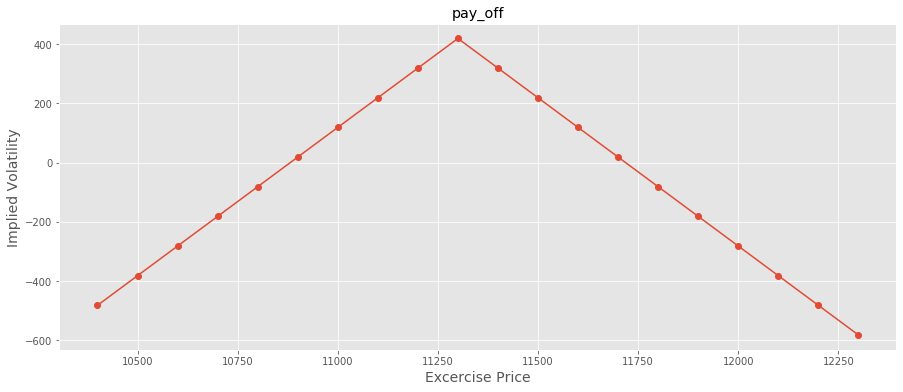

In [66]:
# plot the Implied Volatility

plt.style.use('ggplot')
plt.figure(figsize=(15,6))
plt.plot(s_list, pnl,  marker='o')
#plt.axvline(x = S, linestyle = 'dashed', color = 'black')

title_name = "pay_off"
plt.title(title_name)
plt.xlabel('Excercise Price', fontsize=14)
plt.ylabel('Implied Volatility', fontsize=14)